In [1]:
import numpy as np

from matplotlib import pyplot as plt
from src.environments.mg_simple import MGSimple

## Zero agent

In [2]:
batch_size = 1
env = MGSimple(batch_size=batch_size, steps=24, min_temp=29, max_temp=31, peak_pv_gen=1, peak_conv_gen=1, peak_load=1)

# Initialize states and rewards

state_0, r_0, done, _ = env.reset()

states_za, rewards_za, actions_za = [], [], []

while not done:

    action = np.zeros((batch_size, 1))

    s_t, r_t, done, _ = env.step(action)

    states_za.append(s_t)
    rewards_za.append(r_t)
    actions_za.append(action)

states_za = np.stack(states_za, axis=1)
rewards_za = np.stack(rewards_za, axis=1)
actions_za = np.stack(actions_za, axis=1)

# Random Agent

In [3]:
batch_size = 1
env = MGSimple(batch_size=batch_size, steps=24, min_temp=29, max_temp=31, peak_pv_gen=1, peak_conv_gen=1, peak_load=1)

# Initialize states and rewards

state_0, r_0, done, _ = env.reset()

states_ra, rewards_ra, actions_ra = [], [], []

while not done:

    action = np.random.uniform(low=-1, high=1, size=(batch_size, 1))

    s_t, r_t, done, _ = env.step(action)

    states_ra.append(s_t)
    rewards_ra.append(r_t)
    actions_ra.append(action)

states_ra = np.stack(states_ra, axis=1)
rewards_ra = np.stack(rewards_ra, axis=1)
actions_ra = np.stack(actions_ra, axis=1)

# A2C Causality cont.

In [2]:
import traceback

from src.environments.mg_simple import MGSimple
from src.rl.a2c.c_mg_simple import Agent, set_all_seeds

# Get arguments from command line

disable_logging = False
disable_noise = True
batch_size = 8
training_steps = 1500
rollout_steps = 24
actor_lr = 0.0001
critic_lr = 0.001
actor_nn = 64
critic_nn = 64
gamma = 1
enable_gpu = True
central_agent = False # Not needed yet
random_soc_0 = False
encoding = False # Not needed yet
extended_observation = False # Not needed yet
epsilon = 0.001

# Start wandb logger

try:

    '''
        Setup all the configurations for Wandb
    '''

    wdb_config={
        "training_steps": training_steps,
        "batch_size": batch_size,
        "rollout_steps": rollout_steps,
        "agent_actor_lr": actor_lr,
        "agent_critic_lr": critic_lr,
        "agent_actor_nn": actor_nn,
        "agent_critic_nn": critic_nn,
        "gamma": gamma,
        "central_agent": central_agent,
        "random_soc_0": random_soc_0,
        "encoding": encoding,
        "extended_observation": extended_observation,
        "epsilon": epsilon,
    }

    '''
        Run the simulator
    '''

    set_all_seeds(0)

    # Instantiate the environment

    my_env = MGSimple(
        batch_size=batch_size, steps = rollout_steps, min_temp = 29, max_temp = 31, peak_pv_gen = 1, peak_conv_gen = 1, peak_load = 1,
        random_soc_0=random_soc_0, disable_noise=disable_noise
    )

    # Instantiate the agent

    agent = Agent(
        env=my_env, critic_lr=critic_lr, actor_lr=actor_lr, actor_nn=actor_nn, critic_nn=critic_nn, batch_size=batch_size, gamma=gamma,
        extended_obs=extended_observation, wandb_dict=wdb_config, enable_gpu=enable_gpu, disable_wandb=disable_logging,
    )

    # Launch the training

    all_states, all_rewards, all_actions = agent.train(training_steps=training_steps, epsilon=epsilon)

    # Finish Wandb execution

    agent.wdb_logger.finish()

except (RuntimeError, KeyboardInterrupt):

    traceback.print_exc()

/Users/guti/miniforge3/envs/bcte/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guti. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/guti/.netrc
wandb: Currently logged in as: guti (optimllab). Use `wandb login --relogin` to force relogin


Running on CPU


  0%|          | 0/1500 [00:00<?, ?it/s]

Saving model on step: 0

  0%|          | 2/1500 [00:00<03:49,  6.54it/s]

  4%|▎         | 53/1500 [00:04<01:40, 14.40it/s]

Saving model on step: 50


  7%|▋         | 103/1500 [00:07<01:39, 14.04it/s]

Saving model on step: 100


 10%|█         | 153/1500 [00:11<01:36, 13.98it/s]

Saving model on step: 150


 14%|█▎        | 203/1500 [00:14<01:29, 14.48it/s]

Saving model on step: 200


 17%|█▋        | 253/1500 [00:18<01:32, 13.48it/s]

Saving model on step: 250


 20%|██        | 303/1500 [00:22<01:24, 14.16it/s]

Saving model on step: 300


 24%|██▎       | 353/1500 [00:25<01:23, 13.77it/s]

Saving model on step: 350


 27%|██▋       | 403/1500 [00:29<01:16, 14.25it/s]

Saving model on step: 400


 30%|███       | 453/1500 [00:32<01:13, 14.20it/s]

Saving model on step: 450


 34%|███▎      | 503/1500 [00:36<01:12, 13.70it/s]

Saving model on step: 500


 37%|███▋      | 553/1500 [00:39<01:05, 14.37it/s]

Saving model on step: 550


 40%|████      | 603/1500 [00:43<01:06, 13.48it/s]

Saving model on step: 600


 44%|████▎     | 653/1500 [00:47<01:07, 12.61it/s]

Saving model on step: 650


 47%|████▋     | 703/1500 [00:50<00:55, 14.30it/s]

Saving model on step: 700


 50%|█████     | 753/1500 [00:54<00:52, 14.16it/s]

Saving model on step: 750


 54%|█████▎    | 803/1500 [00:57<00:48, 14.30it/s]

Saving model on step: 800


 57%|█████▋    | 853/1500 [01:01<00:47, 13.66it/s]

Saving model on step: 850


 60%|██████    | 903/1500 [01:04<00:41, 14.27it/s]

Saving model on step: 900


 64%|██████▎   | 953/1500 [01:08<00:38, 14.33it/s]

Saving model on step: 950


 67%|██████▋   | 1003/1500 [01:12<00:35, 14.08it/s]

Saving model on step: 1000


 70%|███████   | 1053/1500 [01:15<00:32, 13.89it/s]

Saving model on step: 1050


 74%|███████▎  | 1103/1500 [01:19<00:29, 13.65it/s]

Saving model on step: 1100


 77%|███████▋  | 1153/1500 [01:22<00:25, 13.85it/s]

Saving model on step: 1150


 80%|████████  | 1203/1500 [01:26<00:21, 13.75it/s]

Saving model on step: 1200


 84%|████████▎ | 1253/1500 [01:30<00:18, 13.66it/s]

Saving model on step: 1250


 87%|████████▋ | 1303/1500 [01:33<00:14, 13.85it/s]

Saving model on step: 1300


 90%|█████████ | 1353/1500 [01:37<00:10, 13.51it/s]

Saving model on step: 1350


 94%|█████████▎| 1403/1500 [01:41<00:07, 13.38it/s]

Saving model on step: 1400


 97%|█████████▋| 1453/1500 [01:44<00:03, 13.27it/s]

Saving model on step: 1450


100%|██████████| 1500/1500 [01:48<00:00, 13.85it/s]


actor_loss,▁███▇██▇▇█▇▇██▇█▇███▇▇▇▇▇▇▇█▇▇█▇█▇█▇▇█▇▇
avg_action,▅▄▄▃▅▆▅▅▅▅██▅▃▁▇▇▇▆▆▆▇▇▇▆▆▆▅▆▆▆▇▆▇▇▆▅▅▄▅
critic_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout_avg_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
actor_loss,0.0267
avg_action,0.91834
critic_loss,0.00595
rollout_avg_reward,-5.19114


# A2C Causality disc.

In [5]:
import traceback

from src.environments.mg_simple import MGSimple
from src.rl.a2c.d_mg_simple import Agent, set_all_seeds

# Get arguments from command line

disable_logging = True
batch_size = 8
training_steps = 1500
rollout_steps = 24
actor_lr = 0.0001
critic_lr = 0.001
actor_nn = 64
critic_nn = 64
gamma = 1
enable_gpu = True
central_agent = False # Not needed yet
random_starting_step = True # Need to be refactored to random soc_0
encoding = False # Not needed yet
extended_observation = False # Not needed yet
epsilon = 0.001

# Start wandb logger

try:

    '''
        Setup all the configurations for Wandb
    '''

    wdb_config={
        "training_steps": training_steps,
        "batch_size": batch_size,
        "rollout_steps": rollout_steps,
        "agent_actor_lr": actor_lr,
        "agent_critic_lr": critic_lr,
        "agent_actor_nn": actor_nn,
        "agent_critic_nn": critic_nn,
        "gamma": gamma,
        "central_agent": central_agent,
        "random_starting_step": random_starting_step,
        "encoding": encoding,
        "extended_observation": extended_observation,
        "epsilon": epsilon,
    }

    '''
        Run the simulator
    '''

    set_all_seeds(0)

    # Instantiate the environment

    my_env = MGSimple(batch_size=batch_size, steps = rollout_steps, min_temp = 29, max_temp = 31, peak_pv_gen = 1, peak_conv_gen = 1, peak_load = 1)

    # Instantiate the agent

    agent = Agent(
        env=my_env, critic_lr=critic_lr, actor_lr=actor_lr, actor_nn=actor_nn, critic_nn=critic_nn, batch_size=batch_size, gamma=gamma,
        extended_obs=extended_observation, wandb_dict=wdb_config, enable_gpu=enable_gpu, disable_wandb=disable_logging,
    )

    # Launch the training

    all_states, all_rewards, all_actions = agent.train(training_steps=training_steps, epsilon=epsilon)

    # Finish Wandb execution

    agent.wdb_logger.finish()

except (RuntimeError, KeyboardInterrupt):

    traceback.print_exc()

print('A2C training completed')

Running on CPU


  0%|          | 0/1500 [00:00<?, ?it/s]

rollout_avg_reward: -7.480491638183594 
actor_loss: -29.290441513061523 
critic_loss: 52.78401565551758 
avg_action: -0.40394648829431434 


  0%|          | 0/1500 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './models/model.pt'

# Plots

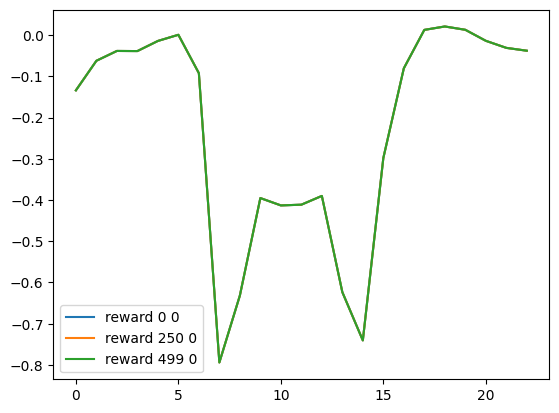

In [3]:
all_rewards = np.stack(all_rewards, axis=0).squeeze()
all_actions = np.stack(all_actions, axis=0).squeeze()
all_states = np.stack(all_states, axis=0).squeeze()

plt.plot(all_rewards[0,:,0], label='reward 0 0')
plt.plot(all_rewards[250,:,0], label='reward 250 0')
plt.plot(all_rewards[499,:,0], label='reward 499 0')
plt.legend()
plt.show()

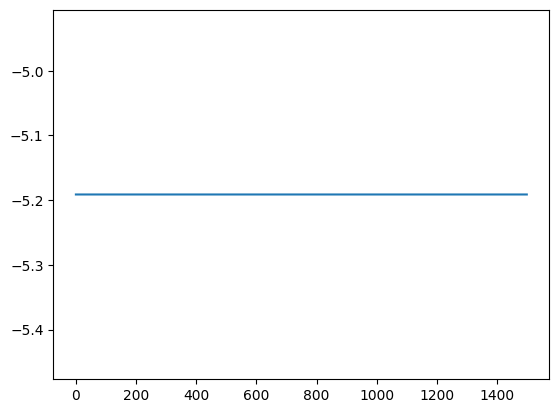

In [4]:
avg_reward = all_rewards.sum(axis=1).mean(axis=1)

plt.plot(avg_reward)
plt.show()

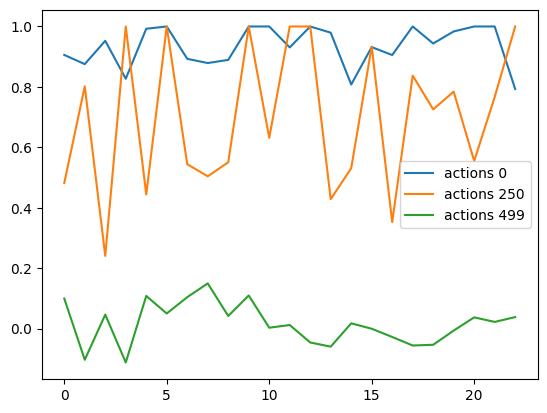

In [ ]:
plt.plot(all_actions[0,:,0], label='actions 0')
plt.plot(all_actions[250,:,0], label='actions 250')
plt.plot(all_actions[1499,:,0], label='actions 499')
plt.legend()
plt.show()

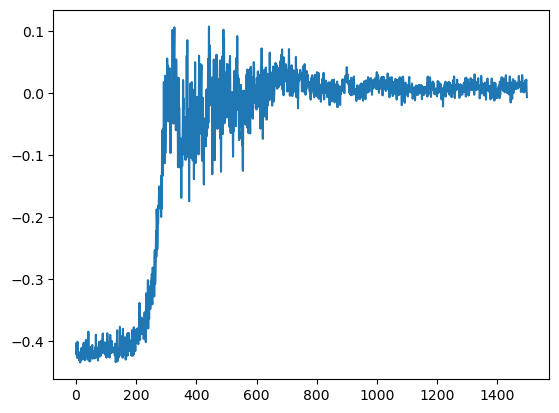

In [ ]:
avg_action = all_actions.mean(axis=1).mean(axis=1)

plt.plot(avg_action)
plt.show()

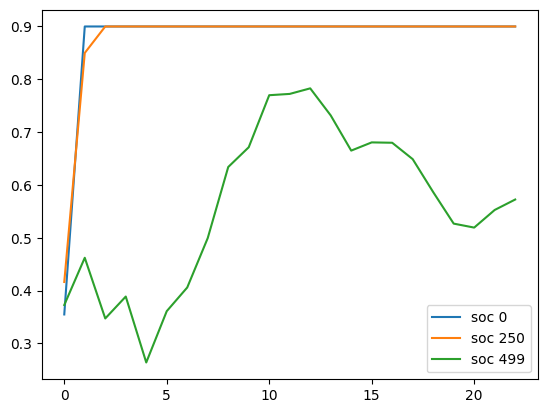

In [ ]:
all_socs = all_states[:,:,:,8]

plt.plot(all_socs[0,:,0], label='soc 0')
plt.plot(all_socs[250,:,0], label='soc 250')
plt.plot(all_socs[1499,:,0], label='soc 499')
plt.legend()
plt.show()

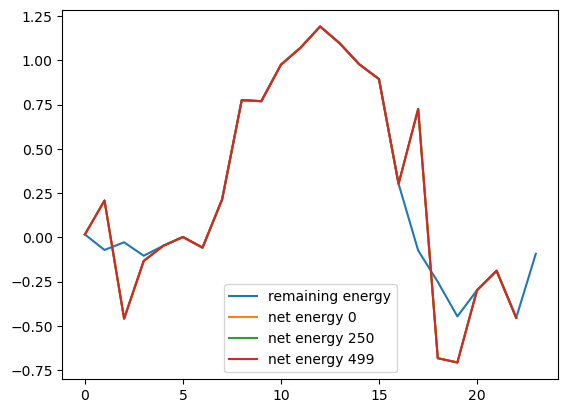

In [ ]:
all_net_energy = all_states[:,:,:,4]
remaining_energy = my_env.mg.remaining_energy

plt.plot(remaining_energy, label='remaining energy')
plt.plot(all_net_energy[0,:,0], label='net energy 0')
plt.plot(all_net_energy[250,:,0], label='net energy 250')
plt.plot(all_net_energy[499,:,0], label='net energy 499')
plt.legend()
plt.show()

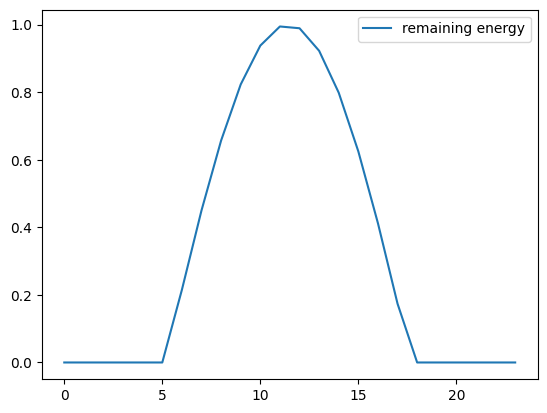

In [ ]:
remaining_energy = my_env.mg.pv_gen

remaining_energy.shape

plt.plot(remaining_energy, label='remaining energy')
plt.legend()
plt.show()